In [1]:
import numpy as np
import keras
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten,Dropout,BatchNormalization,AveragePooling2D,concatenate,Input, concatenate,GlobalAveragePooling2D
from keras.models import Model,load_model
from keras.optimizers import Adam
from keras.layers import Add

Using TensorFlow backend.


In [2]:
#Define convolution with batchnromalization
def Conv2d_BN(x, nb_filter,kernel_size, padding='same',strides=(1,1),name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None

    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,activation='relu',name=conv_name)(x)
    x = BatchNormalization(axis=3,name=bn_name)(x)
    return x

In [3]:
#Define Residual Block for ResNet34(2 convolution layers)
def Residual_Block(input_model,nb_filter,kernel_size,strides=(1,1), with_conv_shortcut =False):
    x = Conv2d_BN(input_model,nb_filter=nb_filter,kernel_size=kernel_size,strides=strides,padding='same')
    x = Conv2d_BN(x, nb_filter=nb_filter, kernel_size=kernel_size,padding='same')
    
    #need convolution on shortcut for add different channel
    if with_conv_shortcut:
        shortcut = Conv2d_BN(input_model,nb_filter=nb_filter,strides=strides,kernel_size=kernel_size)
        #x = add([x,shortcut])
        #x = concatenate([x, shortcut], axis=-1)
        x = Add()([x, shortcut])
        #x = shortcut
        return x
    else:
        #x = add([x,input_model])
        #x = concatenate([x, input_model], axis=-1)
        x = Add()([x, input_model])
        #x = input_model
        return x

In [4]:
#Built ResNet34
def ResNet34(width, height, depth, classes):
    
    Img = Input(shape=(width,height,depth))
    
    x = Conv2d_BN(Img,64,(7,7),strides=(2,2),padding='same')
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)  

    #Residual conv2_x ouput 56x56x64 
    x = Residual_Block(x,nb_filter=64,kernel_size=(3,3))
    x = Residual_Block(x,nb_filter=64,kernel_size=(3,3))
    x = Residual_Block(x,nb_filter=64,kernel_size=(3,3))
    
    #Residual conv3_x ouput 28x28x128 
    x = Residual_Block(x,nb_filter=128,kernel_size=(3,3),strides=(2,2),with_conv_shortcut=True)# need do convolution to add different channel
    x = Residual_Block(x,nb_filter=128,kernel_size=(3,3))
    x = Residual_Block(x,nb_filter=128,kernel_size=(3,3))
    x = Residual_Block(x,nb_filter=128,kernel_size=(3,3))
    
    #Residual conv4_x ouput 14x14x256
    x = Residual_Block(x,nb_filter=256,kernel_size=(3,3),strides=(2,2),with_conv_shortcut=True)# need do convolution to add different channel
    x = Residual_Block(x,nb_filter=256,kernel_size=(3,3))
    x = Residual_Block(x,nb_filter=256,kernel_size=(3,3))
    x = Residual_Block(x,nb_filter=256,kernel_size=(3,3))
    x = Residual_Block(x,nb_filter=256,kernel_size=(3,3))
    x = Residual_Block(x,nb_filter=256,kernel_size=(3,3))
    
    #Residual conv5_x ouput 7x7x512
    x = Residual_Block(x,nb_filter=512,kernel_size=(3,3),strides=(2,2),with_conv_shortcut=True)
    x = Residual_Block(x,nb_filter=512,kernel_size=(3,3))
    x = Residual_Block(x,nb_filter=512,kernel_size=(3,3))


    #Using AveragePooling replace flatten
    x = GlobalAveragePooling2D()(x)
    x = Dense(classes,activation='softmax')(x)
    
    model=Model(input=Img,output=x)
    return model  

In [5]:
Resnet_Model=ResNet34(64,64,3,200)

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [6]:
Resnet_Model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display

In [8]:
import pathlib
PATH='C:/Users/User/tiny-imagenet-200/'
train_dir=os.path.join(PATH,'train')
val_dir=os.path.join(PATH,'validation')
train_dir=pathlib.Path(train_dir)
val_dir=pathlib.Path(val_dir)
print(train_dir)

C:\Users\User\tiny-imagenet-200\train


In [9]:
train_image_count=len(list(train_dir.glob('*/images/*.jpeg')))
print(train_image_count)
val_image_count=len(list(val_dir.glob('*/images/*.jpeg')))
print(val_image_count)

100000
100000


In [10]:
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*')])
CLASS_NAMES

array(['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640',
       'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750',
       'n01784675', 'n01855672', 'n01882714', 'n01910747', 'n01917289',
       'n01944390', 'n01945685', 'n01950731', 'n01983481', 'n01984695',
       'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02085620',
       'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799',
       'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165',
       'n02132136', 'n02165456', 'n02190166', 'n02206856', 'n02226429',
       'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972',
       'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003',
       'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495',
       'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666196',
       'n02669723', 'n02699494', 'n02730930', 'n02769748', 'n02788148',
       'n02791270', 'n02793495', 'n02795169', 'n02802426', 'n028

In [11]:
train_image_generator = ImageDataGenerator(
                    rescale=1./255,
                    #rotation_range=45,
                    #width_shift_range=.15,
                    #height_shift_range=.15,
                    #horizontal_flip=True,
                    #zoom_range=0.5
                    )
val_image_generator = ImageDataGenerator(
                    rescale=1./255,
                    #rotation_range=45,
                    #width_shift_range=.15,
                    #height_shift_range=.15,
                    #horizontal_flip=True,
                    #zoom_range=0.5
                    )

In [12]:
BATCH_SIZE = 256
IMG_HEIGHT = 64
IMG_WIDTH = 64
STEPS_PER_EPOCH = np.ceil(train_image_count/BATCH_SIZE)

In [13]:
STEPS_PER_EPOCH

391.0

In [14]:
train_data_generator = train_image_generator.flow_from_directory(directory=str(train_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))
val_data_generator = val_image_generator.flow_from_directory(directory=str(val_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 100000 images belonging to 200 classes.
Found 100000 images belonging to 200 classes.


In [15]:
Resnet_Model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
model_dir='lab2-logs-Imagenet200/models/'
os.makedirs(model_dir)

In [17]:
import tensorflow as tf
log_dir=os.path.join('lab2-logs-Imagenet200','model-1')
model_callback= tf.keras.callbacks.TensorBoard(log_dir=log_dir)
model_MakeCheckPoint=tf.keras.callbacks.ModelCheckpoint(model_dir+'Best-model-1.h5',
                                                       monitor='val_acc',
                                                       save_best_only=True,
                                                       #mode='min',
                                                       verbose=1)

In [18]:
history2 = Resnet_Model.fit_generator(train_data_generator,
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=30,
                    validation_data=val_data_generator,
                    validation_steps=200,
                    verbose=1,
                    callbacks=[model_callback,model_MakeCheckPoint]
)
Resnet_Model.save_weights("saved_models/ResNet_Imagenet200_epoch1to30.h5")
print("Save model ResNet_Imagenet200_epoch1to30 successful")

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
391/391 [==============================] - 265s 677ms/step - loss: 4.3973 - acc: 0.1005 - val_loss: 4.3603 - val_acc: 0.1255

Epoch 00001: val_acc improved from -inf to 0.12551, saving model to lab2-logs-Imagenet200/models/Best-model-1.h5
Epoch 2/30
391/391 [==============================] - 194s 497ms/step - loss: 3.5048 - acc: 0.2160 - val_loss: 3.9843 - val_acc: 0.1557

Epoch 00002: val_acc improved from 0.12551 to 0.15572, saving model to lab2-logs-Imagenet200/models/Best-model-1.h5
Epoch 3/30
391/391 [==============================] - 179s 458ms/step - loss: 3.0344 - acc: 0.2972 - val_loss: 2.8999 - val_acc: 0.3182

Epoch 00003: val_acc improved from 0.15572 to 0.31824, saving model to lab2-logs-Imagenet200/models/Best-model-1.h5
Epoch 4/30
391/391 [==============================] - 181s 463ms/step - loss: 2.6450 - acc: 0.3672 - val_loss: 2.3936 - val_acc: 0.4170

Epoch 00004: val_acc improved from 0.31824 to 0.41699, savi

In [19]:
Resnet_Model.load_weights('C:/Users/User/lab2-logs-Imagenet200/models/Best-model-1.h5')

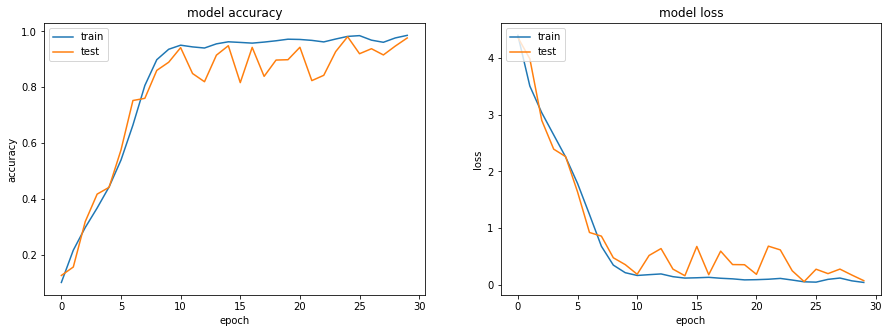

In [20]:
#Plot Loss and accuracy
import matplotlib.pyplot as plt
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.show()

In [21]:
class_names = sorted(val_data_generator.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
print(class_names)
image_batch_val, label_batch_val = next(val_data_generator)

predicted_batch = Resnet_Model.predict(image_batch_val)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

['N01443537' 'N01629819' 'N01641577' 'N01644900' 'N01698640' 'N01742172'
 'N01768244' 'N01770393' 'N01774384' 'N01774750' 'N01784675' 'N01855672'
 'N01882714' 'N01910747' 'N01917289' 'N01944390' 'N01945685' 'N01950731'
 'N01983481' 'N01984695' 'N02002724' 'N02056570' 'N02058221' 'N02074367'
 'N02085620' 'N02094433' 'N02099601' 'N02099712' 'N02106662' 'N02113799'
 'N02123045' 'N02123394' 'N02124075' 'N02125311' 'N02129165' 'N02132136'
 'N02165456' 'N02190166' 'N02206856' 'N02226429' 'N02231487' 'N02233338'
 'N02236044' 'N02268443' 'N02279972' 'N02281406' 'N02321529' 'N02364673'
 'N02395406' 'N02403003' 'N02410509' 'N02415577' 'N02423022' 'N02437312'
 'N02480495' 'N02481823' 'N02486410' 'N02504458' 'N02509815' 'N02666196'
 'N02669723' 'N02699494' 'N02730930' 'N02769748' 'N02788148' 'N02791270'
 'N02793495' 'N02795169' 'N02802426' 'N02808440' 'N02814533' 'N02814860'
 'N02815834' 'N02823428' 'N02837789' 'N02841315' 'N02843684' 'N02883205'
 'N02892201' 'N02906734' 'N02909870' 'N02917067' 'N

In [22]:
label_id = np.argmax(label_batch_val, axis=-1)

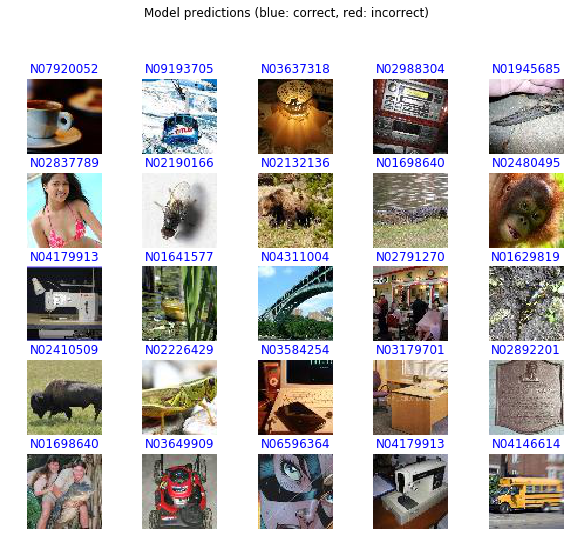

In [23]:
image_batch_val, label_batch_val = next(val_data_generator)
predicted_batch = Resnet_Model.predict(image_batch_val)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch_val, axis=-1)

plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.25)
for n in range(25):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch_val[n])
  color = "blue" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")